# Engineering Predictive Alpha Factors

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

> For illustration, this notebook produces many more factors than suggested by the milestone instructions!

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

> You can also upload and run this notebook in [google collab](https://colab.research.google.com/notebooks/intro.ipynb), just install the packages required by the below imports, mount you Google Drive as described [here](https://buomsoo-kim.github.io/colab/2020/05/09/Colab-mounting-google-drive.md/) and update the `DATA_STORE` to the location on your Google Drive (relative to you mount path) with the `HDFStore` containing the Quandl dataset we created in the first milestone.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install pandas_datareader

In [3]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [5]:
DATA_STORE = Path('stock_prices_rev3.h5')

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['us_stocks_rev3']
            .loc[idx[:, '2006':'2016'], :]  # slice 11 years from 2nd level of MultiIndex using pd.IndexSlice 
            .unstack('ticker') # move first index level 'ticker' into the columns
            .sort_index() 
            .fillna(method='ffill', limit=5) # fill up to five days of missing data with latest
            .stack('ticker') # move Index level 'ticker' back into the rows
            .swaplevel()     # swap levels of row index so we're back at (ticker, data)
            .dropna()        # remove missing values
            .sort_index())

## Remove outliers based on daily returns

In [9]:
daily_returns = data.groupby('ticker').close.pct_change() # returns computed based on closing prices

In [10]:
daily_returns.describe(percentiles=[.00001, .0001, .001, .999, .9999, .99999]).iloc[1:]

mean         0.000776
std          0.138084
min         -0.993615
0.001%      -0.706667
0.01%       -0.393002
0.1%        -0.191105
50%          0.000000
99.9%        0.230553
99.99%       0.580756
99.999%      1.783016
max        283.000000
Name: close, dtype: float64

We will only keep returns between -70% and 178%. 

This choice depends on your assumptions at which point daily return values are more likely data errors than actual extreme values. Here, we are choosing a somewhat arbitrary cutoff that you **may want to refine** based on more careful exploratory or historical analysis.

In [11]:
outliers = daily_returns[(daily_returns < daily_returns.quantile(.00001)) |
                         (daily_returns > daily_returns.quantile(.99999))]

In [13]:
data = data.drop(outliers.index.unique('ticker'), level='ticker')

## Select 500 most-traded stocks prior to 2017

In [14]:
dv = data.close*(data.volume)

In [15]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

In [19]:
to_drop = data.index.unique('ticker').difference(top500.index)

In [22]:
data = data.drop(to_drop, level='ticker')

In [24]:
len(data).index.unique('ticker'))

500

In [35]:
ticker = 'AMZN'
price_sample = data.loc[idx[ticker, :], :].reset_index('ticker', drop=True)

In [36]:
price_sample

,open,high,low,close,volume
date,,,,,
2006-01-03,47.470,47.8500,46.25,47.58,7582200.0
2006-01-04,47.485,47.7300,46.69,47.25,7440900.0
2006-01-05,47.160,48.2000,47.11,47.65,5417200.0
2006-01-06,47.970,48.5800,47.32,47.87,6152900.0
2006-01-09,46.550,47.1000,46.40,47.08,8943100.0
...,...,...,...,...,...
2016-12-23,764.550,766.5000,757.99,760.59,1981616.0
2016-12-27,763.400,774.6500,761.20,771.40,2638725.0
2016-12-28,776.250,780.0000,770.50,772.13,3301025.0


## Compute returns

Group data by ticker

In [38]:
by_ticker = data.groupby(level='ticker')

In [39]:
by_ticker

### Historical returns

In [40]:
T = [1, 3, 5, 10, 21, 42, 63, 126, 252]

In [42]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t) # compute returns for each ticker and period

In [43]:
data

open        high         low       close     volume  \
ticker date                                                                    
A      2006-01-03   22.786839   22.909642   22.387796   22.855063  3796200.0   
       2006-01-04   22.889175   23.080202   22.766372   22.916465  3001300.0   
       2006-01-05   22.820951   23.516836   22.820951   23.516836  3458800.0   
       2006-01-06   23.537304   23.735153   23.257585   23.639640  4396500.0   
       2006-01-09   23.639640   23.741976   23.482724   23.571416  2920500.0   
...                       ...         ...         ...         ...        ...   
ZMH    2015-06-29  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-06-30  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-07-01  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-07-02  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-07-06  113.700000  114.090000  113.110000  113.560000  1802629.0   

                     ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
       2006-01-04  0.002687       NaN       NaN       NaN       NaN       NaN   
       2006-01-05  0.026198       NaN       NaN       NaN       NaN       NaN   
       2006-01-06  0.005222  0.034328       NaN       NaN       NaN       NaN   
       2006-01-09 -0.002886  0.028580       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-06-29  0.000000  0.000352  0.001411  0.016925 -0.004645 -0.013496   
       2015-06-30  0.000000  0.002560  0.007810  0.008974 -0.010543  0.035901   
       2015-07-01  0.000000  0.000000  0.000352  0.009422 -0.005256  0.030367   
       2015-07-02  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   
       2015-07-06  0.000000  0.000000  0.000000  0.007989  0.004334  0.029621   

                     ret_63   ret_126   ret_252  
ticker date                                      
A      2006-01-03       NaN       NaN       NaN  
       2006-01-04       NaN       NaN       NaN  
       2006-01-05       NaN       NaN       NaN  
       2006-01-06       NaN       NaN       NaN  
       2006-01-09       NaN       NaN       NaN  
...                     ...       ...       ...  
ZMH    2015-06-29 -0.040370 -0.001540  0.091204  
       2015-06-30 -0.031796  0.004354  0.091516  
       2015-07-01 -0.020713 -0.005026  0.088713  
       2015-07-02 -0.026827  0.005062  0.088713  
       2015-07-06 -0.030476  0.012471  0.095486  

[1402795 rows x 14 columns]

### Forward returns

In [44]:
data['ret_fwd'] = by_ticker.ret_01.shift(-1) # shift returns back in time (tomorrow's returns are today's fwd returns)
data = data.dropna(subset=['ret_fwd'])

In [45]:
data

open        high         low       close     volume  \
ticker date                                                                    
A      2006-01-03   22.786839   22.909642   22.387796   22.855063  3796200.0   
       2006-01-04   22.889175   23.080202   22.766372   22.916465  3001300.0   
       2006-01-05   22.820951   23.516836   22.820951   23.516836  3458800.0   
       2006-01-06   23.537304   23.735153   23.257585   23.639640  4396500.0   
       2006-01-09   23.639640   23.741976   23.482724   23.571416  2920500.0   
...                       ...         ...         ...         ...        ...   
ZMH    2015-06-26  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-06-29  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-06-30  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-07-01  113.700000  114.090000  113.110000  113.560000  1802629.0   
       2015-07-02  113.700000  114.090000  113.110000  113.560000  1802629.0   

                     ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
       2006-01-04  0.002687       NaN       NaN       NaN       NaN       NaN   
       2006-01-05  0.026198       NaN       NaN       NaN       NaN       NaN   
       2006-01-06  0.005222  0.034328       NaN       NaN       NaN       NaN   
       2006-01-09 -0.002886  0.028580       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-06-26  0.002560  0.007810  0.007989  0.012121  0.001499 -0.025243   
       2015-06-29  0.000000  0.000352  0.001411  0.016925 -0.004645 -0.013496   
       2015-06-30  0.000000  0.002560  0.007810  0.008974 -0.010543  0.035901   
       2015-07-01  0.000000  0.000000  0.000352  0.009422 -0.005256  0.030367   
       2015-07-02  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   

                     ret_63   ret_126   ret_252   ret_fwd  
ticker date                                                
A      2006-01-03       NaN       NaN       NaN  0.002687  
       2006-01-04       NaN       NaN       NaN  0.026198  
       2006-01-05       NaN       NaN       NaN  0.005222  
       2006-01-06       NaN       NaN       NaN -0.002886  
       2006-01-09       NaN       NaN       NaN  0.013025  
...                     ...       ...       ...       ...  
ZMH    2015-06-26 -0.031631 -0.001015  0.102026  0.000000  
       2015-06-29 -0.040370 -0.001540  0.091204  0.000000  
       2015-06-30 -0.031796  0.004354  0.091516  0.000000  
       2015-07-01 -0.020713 -0.005026  0.088713  0.000000  
       2015-07-02 -0.026827  0.005062  0.088713  0.000000  

[1402295 rows x 15 columns]

## Persist results

In [48]:
data = pd.read_hdf('my_results_maj_Milstove2.h5', 'data')

### Normalized squeeze & mean reversion indicators

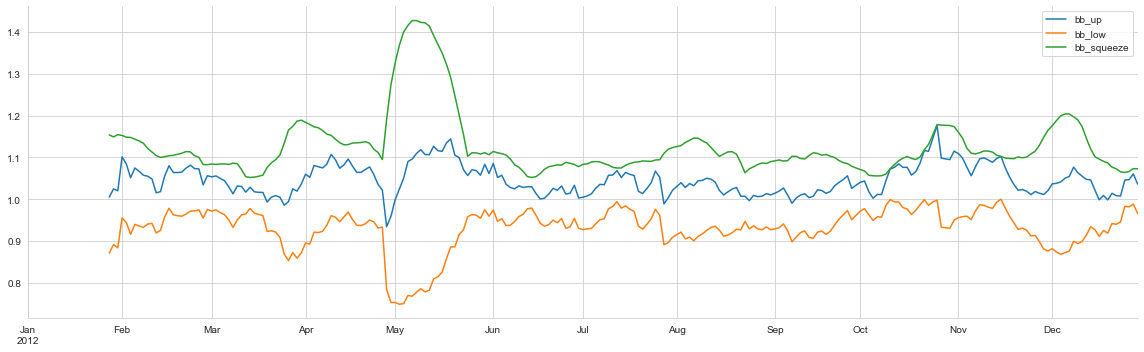

In [65]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [66]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1 # normalize with respect to close
    bb_low = low / close -1 # normalize with respect to close
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

In [67]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_bb_indicators)))

## Momentum Indicators

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

### Average Directional Movement Index (ADX)

The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).

#### Plus/Minus Directional Movement (PLUS_DM/MINUS_DM)

For a price series $P_t$ with daily highs $P^H_t$ and daily lows $P^L_t$, the directional movement tracks the absolute size of price moves over a timeperiod T as follows:

$$\begin{align*}
\text{Up}_t & =P^H_t-P^H_{t-T} \\
\text{Down}_t & = P^L_{t-T} - P^L_t\\
\text{PLUS_DM}_t & = 
\begin{cases}
\text{Up}_t & \text{if Up}_t > \text{Down}_t \text{and Up}_t > 0 \\
0 & \text{otherwise}
\end{cases} \\
\text{MINUS_DM}_t & = 
\begin{cases}
\text{Down}_t & \text{if Down}_t > \text{Up}_t \text{and Down}_t < 0 \\
0 & \text{otherwise}
\end{cases}
\end{align*}$$

In [53]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [54]:
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)

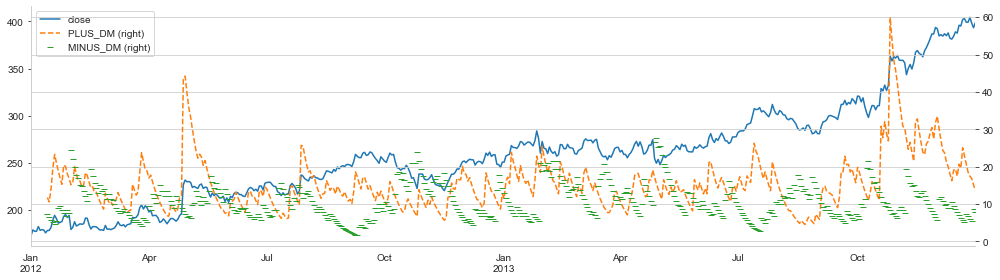

In [55]:
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(14, 4),
                                               secondary_y=[
                                                   'PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'],
                                              rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### Plus/Minus Directional Index (PLUS_DI/MINUS_DI)

`PLUS_DI` and `MINUS_DI` are the simple moving average of `PLUS_DM` and `MINUS_DM`, respectively, each divided by the average true range (`ATR`, see below).

The smoothed moving average is calculated over the number of periods selected, and the average true range is a smoothed average of the true ranges.

In [56]:
df = price_sample.loc['2012': '2013', ['high', 'low', 'close']]

In [57]:
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)

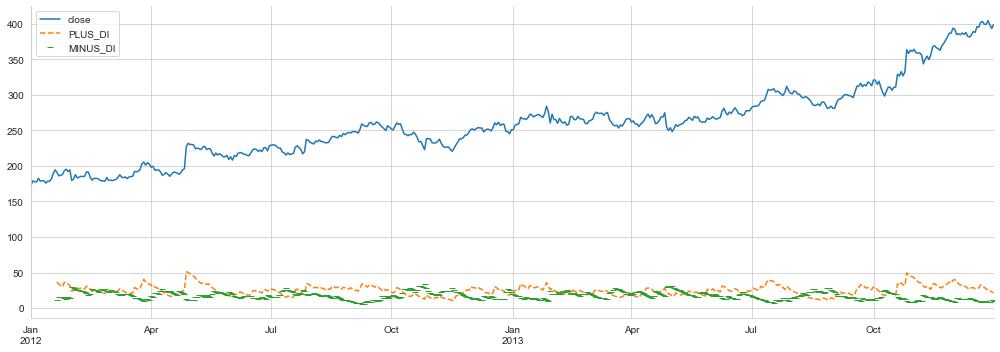

In [58]:
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(14, 5), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### Average directional movement index (ADX)

The ADX is the (simple) moving average of the absolute value of the difference between PLUS_DI and MINUS_DI, divided by their sum:

$$
\text{ADX}=100\times\text{SMA}(N)_t\left|\frac{\text{PLUS_DI}_t-\text{MINUS_DI}_t}{\text{PLUS_DI}_t+\text{MINUS_DI}_t}\right|
$$

|ADX Value|	Trend Strength|
|:---|:---|
|0-25 |	Absent or Weak Trend|
|25-50 |	Strong Trend|
|50-75 |	Very Strong Trend|
|75-100 |	Extremely Strong Trend|

In [59]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [60]:
df['ADX'] = talib.ADX(df.high, 
                      df.low, 
                      df.close, 
                      timeperiod=14)

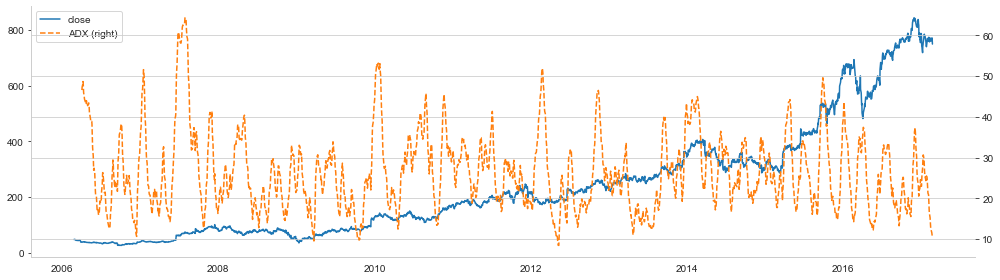

In [61]:
ax = df[['close', 'ADX']].plot(figsize=(14, 4), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [62]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [63]:
data['ADX'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_adx))

### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [87]:
df = price_sample.loc['2013', ['open', 'high', 'low', 'close']]

In [88]:
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)

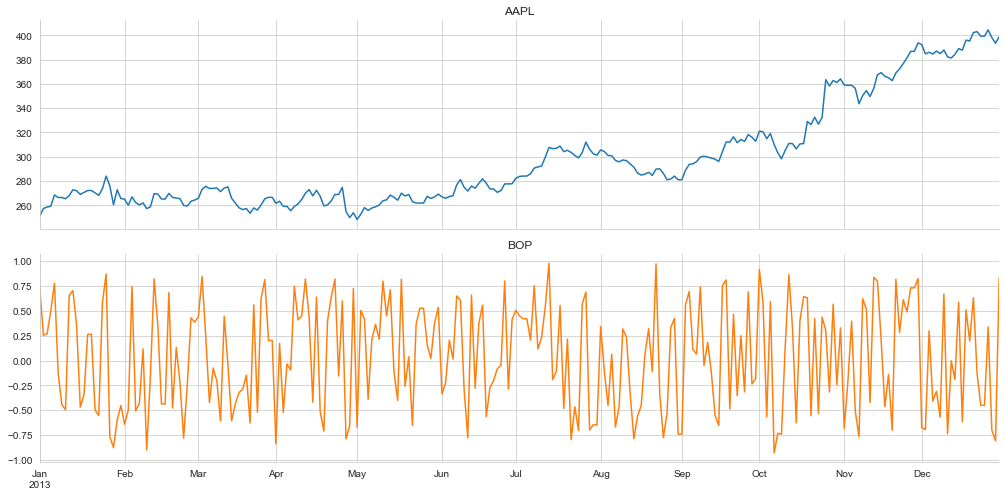

In [89]:
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['AAPL', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

In [90]:
by_ticker = data.groupby('ticker', group_keys=False)

In [91]:
data['BOP'] = (by_ticker
               .apply(lambda x: talib.BOP(x.open,
                                          x.high,
                                          x.low,
                                          x.close)))

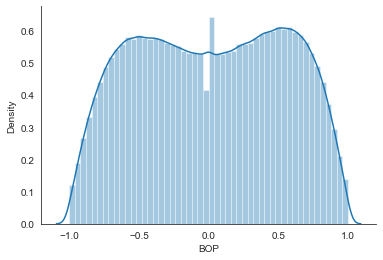

In [92]:
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q),
                               upper=data.BOP.quantile(1-q)))
    sns.despine()

### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

In [98]:
df = price_sample.loc['2013', ['close']]

In [99]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

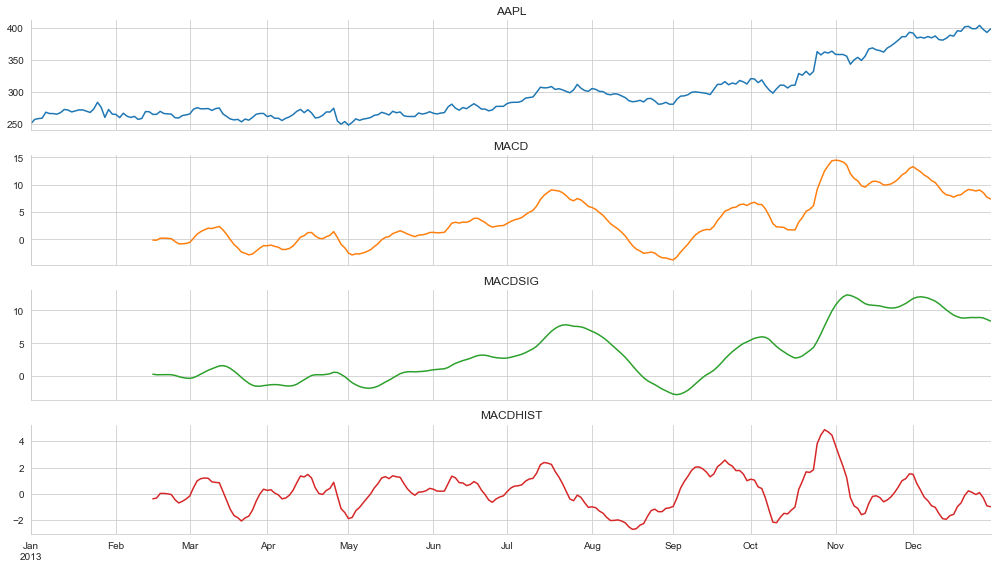

In [100]:
axes = df.plot(figsize=(14, 8),
               rot=0,
               subplots=True,
               title=['AAPL', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [101]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

In [102]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_macd)))

In [103]:
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']

In [104]:
data[macd_indicators].corr()

,MACD,MACD_SIGNAL,MACD_HIST
MACD,1.000000,0.953666,0.355135
MACD_SIGNAL,0.953666,1.000000,0.057425
MACD_HIST,0.355135,0.057425,1.000000


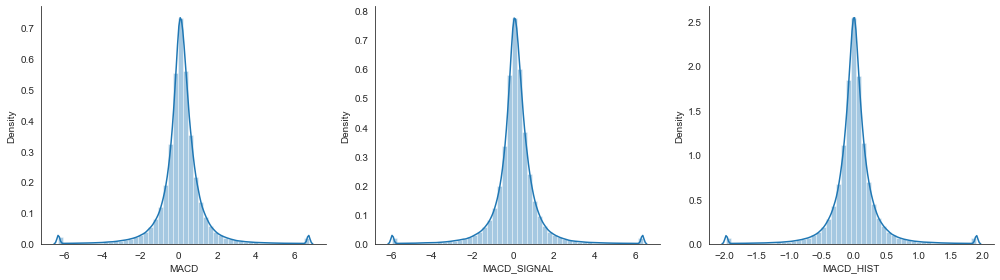

In [105]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

In [111]:
df = price_sample.loc['2013', ['high', 'low', 'close', 'volume']]

In [112]:
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)

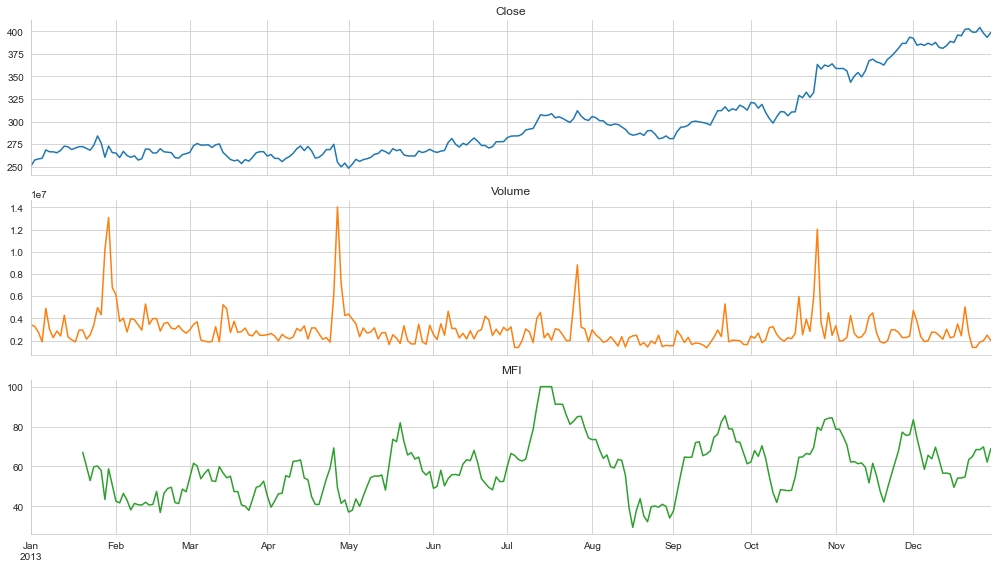

In [113]:
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [114]:
data['MFI'] = (by_ticker
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x.close,
                                          x.volume,
                                          timeperiod=14)))

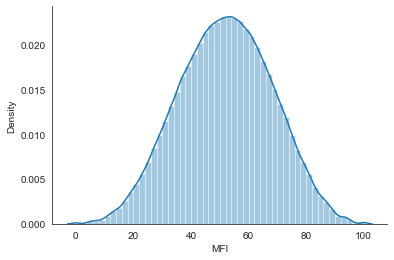

In [115]:
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [116]:
df = price_sample.loc['2013', ['close']]

In [117]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

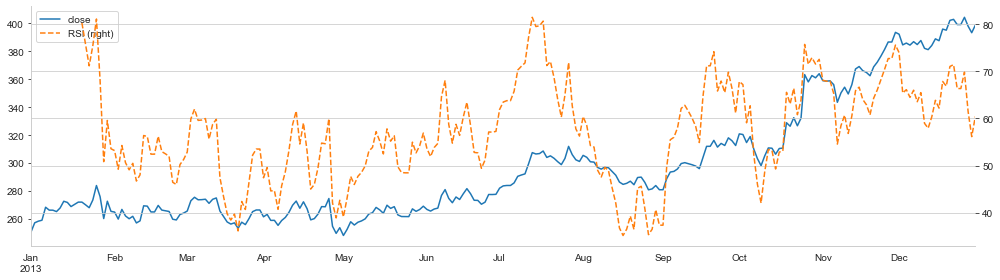

In [118]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [119]:
data['RSI'] = (by_ticker
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))

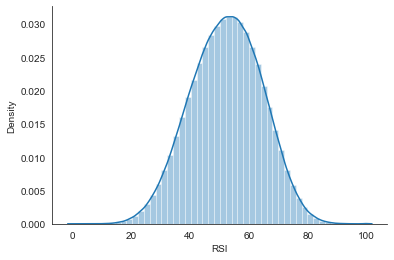

In [120]:
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine();

## Persist results

In [174]:
with pd.HDFStore('data/stock_prices_rev4.h5') as store:  #stock_prices_rev3
    store.put('model_data_maj', data)